# Import Library

In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Downloading Dataset

In [ ]:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
url = 'https://drive.google.com/file/d/1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy/view?usp=sharing'
# Split link to get ID
split1 = url.split('d/')[1]
id = split1.split('/view?')[0]
print(id)

1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy


In [ ]:
# Downloading file
file = drive.CreateFile({'id':id})
file.GetContentFile('Sidewalk_Object_Dataset.zip')

In [ ]:
fzip = 'Sidewalk_Object_Dataset.zip'
zip_ref = zipfile.ZipFile(fzip, 'r')
zip_ref.extractall('./SidewalkDataset')
zip_ref.close()

# Image Augmentation

In [ ]:
train_dir = '/content/SidewalkDataset/train'
val_dir = '/content/SidewalkDataset/val'

In [ ]:
def train_val_generators(training_dir, validation_dir):
  train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      directory=train_dir,
      batch_size=64,
      class_mode='categorical',
      target_size=(150, 150)
  )
  
  val_datagen = ImageDataGenerator(rescale=1/255)

  val_generator = val_datagen.flow_from_directory(
      directory=val_dir,
      batch_size=64,
      class_mode='categorical',
      target_size=(150, 150)
  )

  return train_generator, val_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 2254 images belonging to 9 classes.
Found 466 images belonging to 9 classes.


In [ ]:
train_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [ ]:
validation_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [ ]:
class_names = []
for category in train_generator.class_indices:
  class_names.append(category)

# Transfer Learning: VGG16

In [ ]:
# Import model
from tensorflow.keras.applications.vgg16 import VGG16

model = tf.keras.models.Sequential([
    VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Make the pre-trained model non trainable
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 19,043,145
Trainable params: 4,328,457
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='RMSprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/20
15/36 [===========>..................] - ETA: 36s - loss: 3.5312 - accuracy: 0.3469

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


36/36 [==============================] - 84s 2s/step - loss: 2.0692 - accuracy: 0.5479 - val_loss: 0.3993 - val_accuracy: 0.8906
Epoch 2/20
36/36 [==============================] - 69s 2s/step - loss: 0.6882 - accuracy: 0.7791 - val_loss: 0.4621 - val_accuracy: 0.8734
Epoch 3/20
36/36 [==============================] - 68s 2s/step - loss: 0.5308 - accuracy: 0.8203 - val_loss: 0.3353 - val_accuracy: 0.8884
Epoch 4/20
36/36 [==============================] - 67s 2s/step - loss: 0.5044 - accuracy: 0.8323 - val_loss: 0.2752 - val_accuracy: 0.9034
Epoch 5/20
36/36 [==============================] - 68s 2s/step - loss: 0.3765 - accuracy: 0.8789 - val_loss: 0.3027 - val_accuracy: 0.9013
Epoch 6/20
36/36 [==============================] - 68s 2s/step - loss: 0.3685 - accuracy: 0.8744 - val_loss: 0.2791 - val_accuracy: 0.9142
Epoch 7/20
36/36 [==============================] - 68s 2s/step - loss: 0.3173 - accuracy: 0.8935 - val_loss: 0.3973 - val_accuracy: 0.8648
Epoch 8/20
36/36 [=============

# Plotting Accuracy and Loss

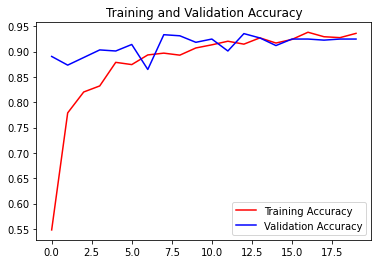

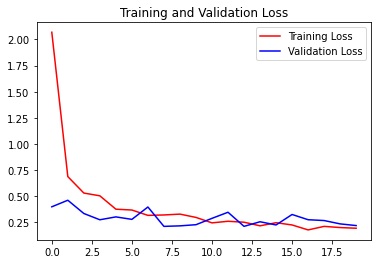

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Export Model

In [ ]:
# Save model to h5 format
model.save('sidewalk_obj_VGG16.h5')

In [ ]:
export_dir = 'saved_model/vgg'
tf.saved_model.save(model, export_dir=export_dir)


INFO:tensorflow:Assets written to: saved_model/vgg/assets


In [ ]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = "sidewalk_obj_VGG16.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('sidewalk_obj_VGG16.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
from google.colab import files
try:
    files.download('sidewalk_obj_VGG16.tflite')
    files.download('sidewalk_obj_VGG16.h5')
    files.download('sidewalk_obj_VGG16.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>